Import libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from ipywidgets import interact,IntSlider
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1 import make_axes_locatable

Import hdf5 file and save arrays to local variables:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
f=h5py.File('/content/drive/My Drive/banyuls_data/fish1_different_speeds.hdf5', 'r')

In [4]:
dict(f.attrs)

{'age': 21, 'date': '2023-01-24', 'line': 'HUC'}

In [5]:
def printname(name):
    print(name)

f.visit(printname)

age
brain
brain/coordinates
brain/fluorescence
brain/times
stimulus
stimulus/direction
stimulus/speed
stimulus/times
tail
tail/coordinates
tail/deflection
tail/deflection_mean
tail/deflection_std
tail/times


In [6]:
def create_variable(name,node):
    if isinstance(node,h5py.Dataset):
        globals()[name.replace('/','_')]=node[...]

f.visititems(create_variable)

In [7]:
f.close()

### Correlation between brain activity and tail movement:

Define some functions:

In [46]:
#signal_times must be linearly spaced
def convolve(signal,signal_times,output_times,t_decay=3.5,t_rise=0.1,window_width_time=60):
    dt=signal_times[1]-signal_times[0]
    tcirf=np.arange(0,int(window_width_time/dt))*dt #only consider points in a window of duration window_width_time, it must be much larger than the charactering time of the cirf
    if t_rise==0: #decaying exponential with decay time t_decay as a calcium impulse response function
        cirf=np.exp(-tcirf/t_decay)
    else: #difference of rising and decaying exponentials with characteristic times t_decay and t_rise
        cirf=np.exp(-tcirf/t_decay)-np.exp(-tcirf/t_rise)
    signal_convolved=np.zeros(len(signal))
    for i in range(len(signal)):
        signal_convolved[i:i+len(cirf)]+=signal[i]*cirf[:len(signal_convolved[i:i+len(cirf)])]
    signal_convolved*=dt #integration timestep
    f_signal_convolved=interp1d(signal_times,signal_convolved,kind='linear',fill_value='extrapolate')
    signal_convolved_int=f_signal_convolved(output_times) #interpolate on the output_times array
    return signal_convolved_int

In [47]:
#signal_times must be linearly spaced
def interpolate(signal,signal_times,output_times,kind='linear'):
    f_signal=interp1d(signal_times,signal,kind=kind,fill_value='extrapolate')
    signal_int=f_signal(output_times) #interpolate on the output_times array
    return signal_int

In [48]:
def center(signal):
    return (signal-np.mean(signal))/np.std(signal)

Threshold the moving standard deviation to set to zero the parts when tha tail is not moving:

In [49]:
threshold=100
tail_deflection_std_thresholded=np.copy(tail_deflection_std)
tail_deflection_std_thresholded[tail_deflection_std<threshold]=0

In [50]:
tail_amplitude_convolved=convolve(tail_deflection_std_thresholded,tail_times,brain_times)

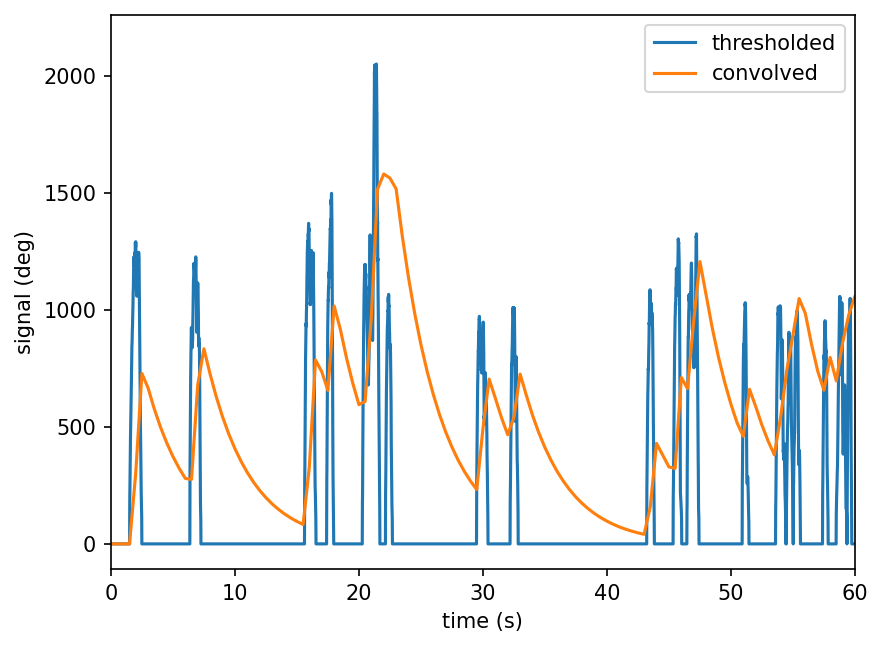

In [51]:
t1=0 #tail_times[0]
t2=60 #tail_times[1]

fig,ax=plt.subplots(dpi=150)

ax.plot(tail_times,tail_deflection_std_thresholded,label='thresholded')
ax.plot(brain_times,tail_amplitude_convolved,label='convolved')
ax.set_xlim(t1,t2)
ax.set_xlabel('time (s)')
ax.set_ylabel('signal (deg)')
ax.legend()

plt.show()

Calculate covariance between convolved tail deflection amplitude and neural fluorescence traces:

In [52]:
signal=center(tail_amplitude_convolved)
covariance=np.zeros(len(brain_fluorescence))
for i in range(len(brain_fluorescence)):
    covariance[i]=np.mean(signal*brain_fluorescence[i]) #calculate covariance between fluorescence and tail movement

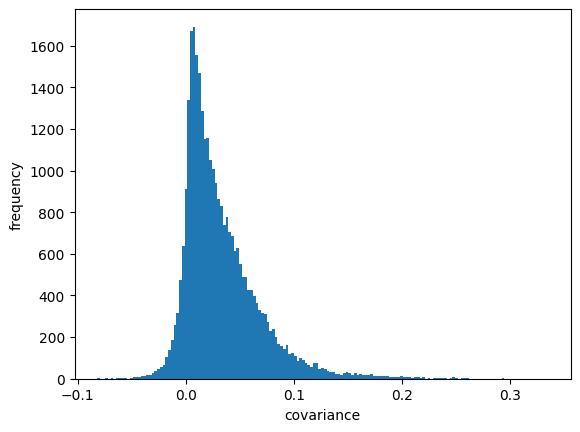

In [53]:
#plot histogram of covariances
fig=plt.figure()
plt.hist(covariance,bins='auto')
plt.xlabel('covariance')
plt.ylabel('frequency')
plt.show()

Find the null distribution of covariances by calculating the covariances with cyclically shifted signals:

In [54]:
n_shifts=5 #number of shifts to construct the null distribution
shifts=(len(brain_times)*np.sqrt(2)*(np.arange(n_shifts)+1)).astype(int)

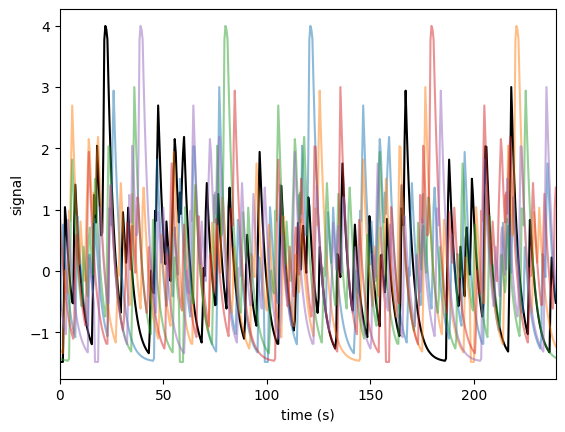

In [55]:
#plot histogram of correlations with shifted signals
fig=plt.figure()
plt.plot(brain_times,signal,'k')
for shift in shifts:
    plt.plot(brain_times,np.roll(signal,shift),alpha=0.5)
plt.xlim(brain_times[0],brain_times[-1])
plt.xlabel('time (s)')
plt.ylabel('signal')
plt.show()

In [56]:
covariance_shifted=[] #covariance with shifted signals
for shift in shifts:
    signal_shifted=np.roll(signal,shift) #shift the signal in time
    for n in range(len(brain_fluorescence)):
        covariance_shifted.append(np.mean(signal_shifted*brain_fluorescence[n])) #calculate the covariance

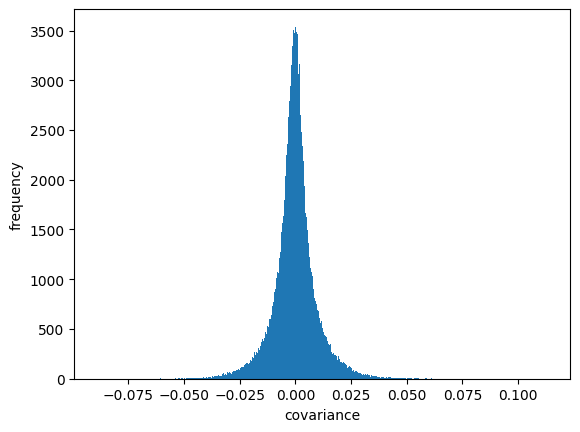

In [57]:
#plot histogram of covariance with shifted signals
fig=plt.figure()
plt.hist(covariance_shifted,bins='auto')
plt.xlabel('covariance')
plt.ylabel('frequency')
plt.show()

In [58]:
#calculate p-values
x=-np.sort(-np.array(covariance_shifted))
y=np.arange(len(x))/len(x)
f_pvalue=interp1d(x,y,kind='previous',fill_value='extrapolate')
pvalue=np.zeros(len(brain_fluorescence))
for n in range(len(brain_fluorescence)):
    pvalue[n]=f_pvalue(covariance[n])

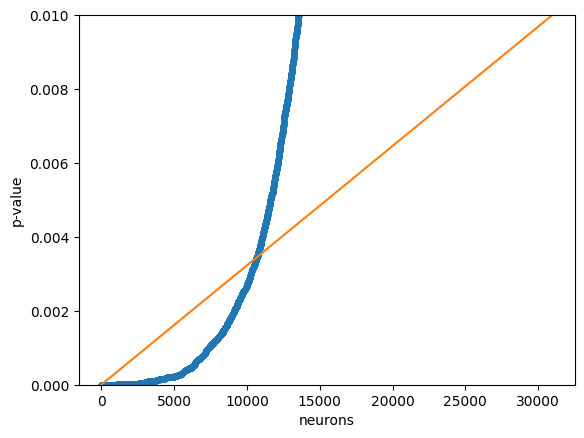

In [59]:
fdr=0.01#false discovery rate
fig=plt.figure()
plt.plot(np.sort(pvalue),'.') #ordered p-values
plt.plot((np.arange(len(pvalue))+1)/len(pvalue)*fdr) #benjamini-hochberg line
plt.ylim(0,fdr)
plt.xlabel('neurons')
plt.ylabel('p-value')
plt.show()

Number of neurons whose activity has a higher-than-chance covariance with the tail deflection amplitude:

In [60]:
#number of significantly correlated neurons according to the benjamini-hochberg procedure:
if len(np.where(np.sort(pvalue)<(np.arange(len(pvalue))+1)/len(pvalue)*fdr)[0])==0:
    n_rejected_neurons=0
else:
    n_rejected_neurons=np.max(np.where(np.sort(pvalue)<(np.arange(len(pvalue))+1)/len(pvalue)*fdr)[0])+1
n_rejected_neurons

10699

In [61]:
indices=np.argsort(-covariance) #indices of all neurons sorted with decreasing correlation
indices_thr=indices[:n_rejected_neurons] #indices of significantly correlated neurons
characteristic=np.zeros(len(brain_fluorescence))
characteristic[indices_thr]=1 #it returns 1 on significantly correlated neurons

In [62]:
#fluorescence traces ordered with decreasing covariance
def f(neuron):
    plt.close()
    fig,ax=plt.subplots(dpi=150)
    ax.plot(brain_times,signal,c='black')
    ax.plot(brain_times,brain_fluorescence[indices[neuron]],'g')
    ax.set_xlim(brain_times[0],brain_times[-1])
    ax.set_xlabel('time (s)')
    ax.set_ylabel('$\Delta F/F$')
    plt.show()

interact(f,neuron=IntSlider(value=0,min=0,max=len(brain_fluorescence)-1,step=1));

interactive(children=(IntSlider(value=0, description='neuron', max=30970), Output()), _dom_classes=('widget-in…

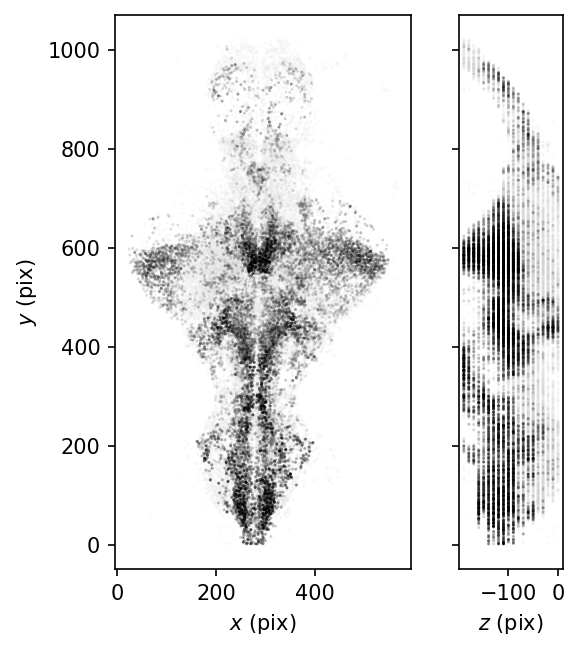

In [63]:
#plot neuron positions colored according to the corresponding covariance
fig, (ax1, ax2) = plt.subplots(1,2,dpi=150,sharey=True)
plt.subplots_adjust(wspace=-0.5)

mask=characteristic.astype(bool)
opacity=covariance/np.max(covariance)
alphas=opacity[mask]
s=2
c='k'

ax1.scatter(brain_coordinates[0,~mask],brain_coordinates[1,~mask],s=s,c='lightgrey',alpha=0.1,edgecolors='none')
ax1.scatter(brain_coordinates[0,mask],brain_coordinates[1,mask],s=s,c=c,alpha=alphas,edgecolors='none')

ax1.set_aspect('equal')
ax1.set_xlabel('$x$ (pix)')
ax1.set_ylabel('$y$ (pix)')

ax2.scatter(brain_coordinates[2,~mask],brain_coordinates[1,~mask],s=s,c='lightgrey',alpha=0.1,edgecolors='none')
ax2.scatter(brain_coordinates[2,mask],brain_coordinates[1,mask],s=s,c=c,alpha=alphas,edgecolors='none')

ax2.set_aspect('equal')
ax2.set_xlabel('$z$ (pix)')

plt.show()

In [64]:
#plots layer by layer
zs=np.unique(brain_coordinates[2])
zs=-np.sort(-zs) #ordered heights of the layers

mask=characteristic.astype(bool)
opacity=covariance/np.max(covariance)

def f(layer):
    plt.close()
    fig,ax=plt.subplots(dpi=150)
    s=1
    offmask_l=(brain_coordinates[2]==zs[layer])&(~mask)
    mask_l=(brain_coordinates[2]==zs[layer])&(mask)
    xlayer=brain_coordinates[0,offmask_l]
    ylayer=brain_coordinates[1,offmask_l]
    ax.scatter(xlayer,ylayer,s=s,c='lightgrey',alpha=0.5)
    xlayer=brain_coordinates[0,mask_l]
    ylayer=brain_coordinates[1,mask_l]
    alphas=opacity[(brain_coordinates[2]==zs[layer])&(mask)]
    if len(xlayer)>0:
        ax.scatter(xlayer,ylayer,s=s,c='black',alpha=alphas)

    ax.set_aspect('equal')
    ax.set_xlim(np.min(brain_coordinates[0]),np.max(brain_coordinates[0]))
    ax.set_ylim(np.min(brain_coordinates[1]),np.max(brain_coordinates[1]))
    ax.set_title('$z = $'+str(zs[layer]))
    ax.set_xlabel('$x$ (pix)')
    ax.set_ylabel('$y$ (pix)')
    plt.show()

interact(f,layer=IntSlider(value=0,min=0,max=len(zs)-1,step=1));

interactive(children=(IntSlider(value=0, description='layer', max=19), Output()), _dom_classes=('widget-intera…

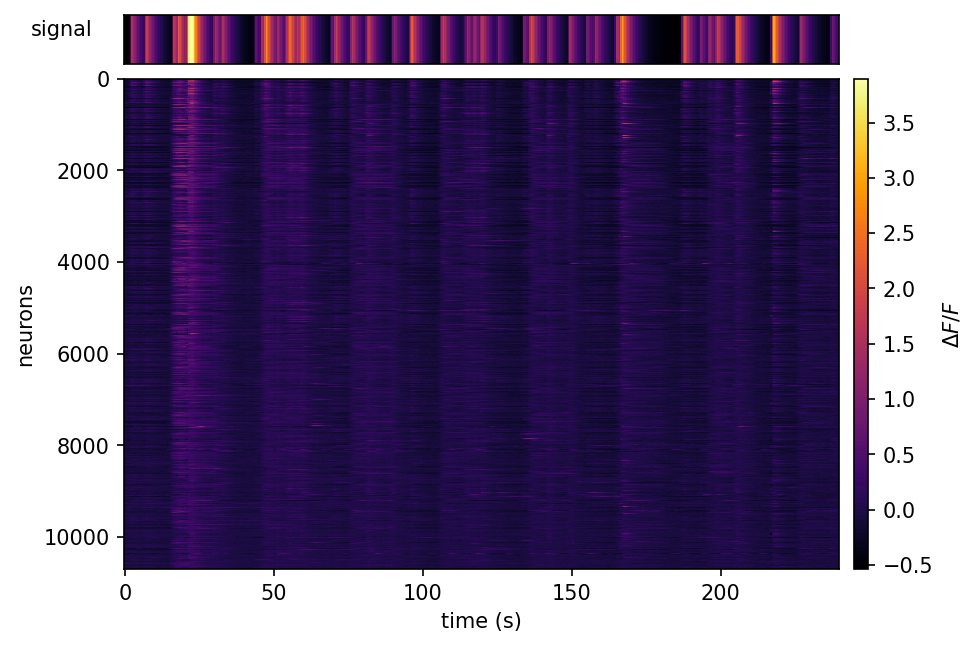

In [65]:
#show fluorescence traces with colormap ordered by decreasing covariance
fig,ax=plt.subplots(dpi=150)
divider=make_axes_locatable(ax)

tax=divider.append_axes('top', size="10%", pad=0.1)
cax=divider.append_axes('right', size="2%", pad=0.1)

dt=(brain_times[-1]-brain_times[0])/len(brain_times)

im1=tax.imshow(np.reshape(signal,(1,-1)),cmap='inferno',interpolation='none',aspect='auto',extent=[brain_times[0]-dt/2,brain_times[-1]+dt/2,len(indices_thr)-0.5,-0.5])

tax.tick_params(axis='both',which='both',bottom=False,left=False,labelbottom=False,labelleft=False)
tax.set_ylabel('signal',rotation=0,labelpad=30)

im2=ax.imshow(brain_fluorescence[indices_thr][:,:],cmap='inferno',interpolation='none',aspect='auto',extent=[brain_times[0]-dt/2,brain_times[-1]+dt/2,len(indices_thr)-0.5,-0.5])

cbar=plt.colorbar(im2,cax=cax)
cbar.set_label(r'$\Delta F/F$')

ax.set_xlabel('time (s)')
ax.set_ylabel('neurons')

plt.show()

Define function to find significantly correlated neurons:

In [66]:
def find_significantly_correlated_neurons(signal,brain_fluorescence,n_shifts=5,fdr=0.01):
    covariance=np.zeros(len(brain_fluorescence))
    for i in range(len(brain_fluorescence)):
        covariance[i]=np.mean(signal*(brain_fluorescence[i])) #calculate covariance between fluorescence and signal

    shifts=(len(brain_times)*np.sqrt(2)*(np.arange(n_shifts)+1)).astype(int)
    covariance_shifted=[] #covariance with shifted signals
    for shift in shifts:
        signal_shifted=np.roll(signal,shift) #shift the signal in time
        for n in range(len(brain_fluorescence)):
            covariance_shifted.append(np.mean(signal_shifted*(brain_fluorescence[n]))) #calculate the covariance

    x=-np.sort(-np.array(covariance_shifted))
    y=np.arange(len(x))/len(x)
    f_pvalue=interp1d(x,y,kind='previous',fill_value='extrapolate')
    pvalue=np.zeros(len(brain_fluorescence))
    for n in range(len(brain_fluorescence)):
        pvalue[n]=f_pvalue(covariance[n])

    if len(np.where(np.sort(pvalue)<(np.arange(len(pvalue))+1)/len(pvalue)*fdr)[0])==0:
        n_rejected_neurons=0
    else:
        n_rejected_neurons=np.max(np.where(np.sort(pvalue)<(np.arange(len(pvalue))+1)/len(pvalue)*fdr)[0])+1

    indices=np.argsort(-covariance) #indices of all neurons sorted with decreasing correlation
    indices_thr=indices[:n_rejected_neurons] #indices of significantly correlated neurons
    characteristic=np.zeros(len(brain_fluorescence))
    characteristic[indices_thr]=1 #it returns 1 on significantly correlated neurons
    return covariance,indices,indices_thr,characteristic

### Covariance with no tail movement:

In [67]:
moving=np.copy(tail_deflection_std)
moving[tail_deflection_std<threshold]=0
moving[tail_deflection_std>=threshold]=1

moving_convolved=convolve(moving,tail_times,brain_times)
not_moving_convolved=-moving_convolved

signal=center(not_moving_convolved)

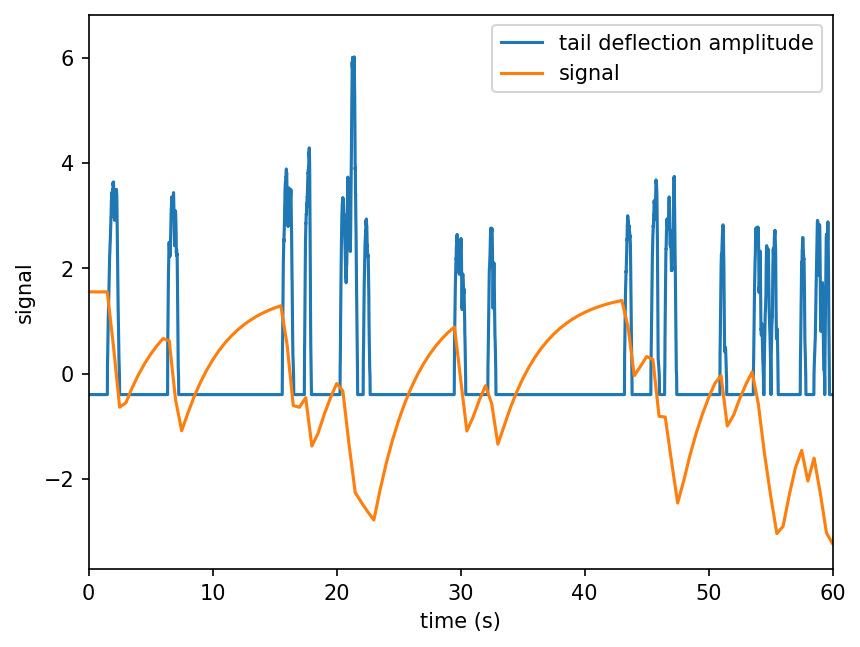

In [68]:
t1=0 #tail_times[0]
t2=60 #tail_times[-1]

fig,ax=plt.subplots(dpi=150)

ax.plot(tail_times,center(tail_deflection_std_thresholded),label='tail deflection amplitude')
ax.plot(brain_times,signal,label='signal')
ax.set_xlim(t1,t2)
ax.set_xlabel('time (s)')
ax.set_ylabel('signal')
ax.legend()

plt.show()

In [69]:
covariance,indices,indices_thr,characteristic=find_significantly_correlated_neurons(signal,brain_fluorescence,fdr=0.2)

In [70]:
len(indices_thr)

11

In [71]:
#fluorescence traces ordered with decreasing covariance
def f(neuron):
    plt.close()
    fig,ax=plt.subplots(dpi=150)
    ax.plot(brain_times,signal,c='black')
    ax.plot(brain_times,brain_fluorescence[indices[neuron]],'g')
    ax.set_xlim(brain_times[0],brain_times[-1])
    ax.set_xlabel('time (s)')
    ax.set_ylabel('$\Delta F/F$')
    plt.show()

interact(f,neuron=IntSlider(value=0,min=0,max=len(brain_fluorescence)-1,step=1));

interactive(children=(IntSlider(value=0, description='neuron', max=30970), Output()), _dom_classes=('widget-in…

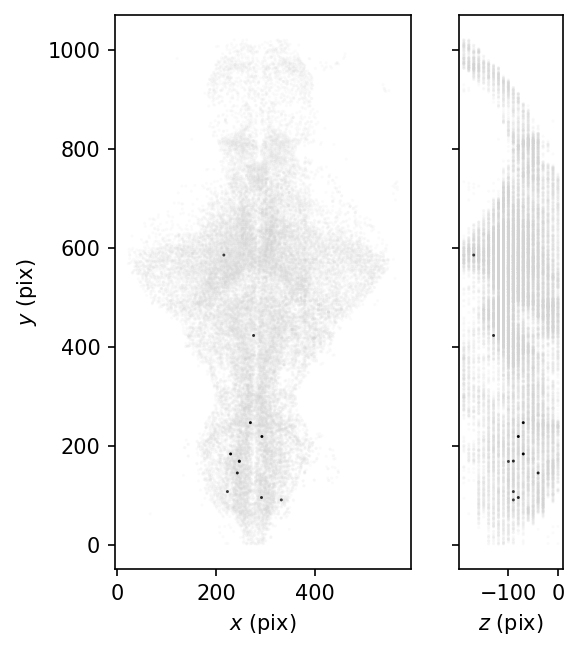

In [72]:
#plot neuron positions colored according to the corresponding covariance
fig, (ax1, ax2) = plt.subplots(1,2,dpi=150,sharey=True)
plt.subplots_adjust(wspace=-0.5)

mask=characteristic.astype(bool)
opacity=covariance/np.max(covariance)
alphas=opacity[mask]
s=2
c='k'

ax1.scatter(brain_coordinates[0,~mask],brain_coordinates[1,~mask],s=s,c='lightgrey',alpha=0.1,edgecolors='none')
ax1.scatter(brain_coordinates[0,mask],brain_coordinates[1,mask],s=s,c=c,alpha=alphas,edgecolors='none')

ax1.set_aspect('equal')
ax1.set_xlabel('$x$ (pix)')
ax1.set_ylabel('$y$ (pix)')

ax2.scatter(brain_coordinates[2,~mask],brain_coordinates[1,~mask],s=s,c='lightgrey',alpha=0.1,edgecolors='none')
ax2.scatter(brain_coordinates[2,mask],brain_coordinates[1,mask],s=s,c=c,alpha=alphas,edgecolors='none')

ax2.set_aspect('equal')
ax2.set_xlabel('$z$ (pix)')

plt.show()

In [73]:
#plots layer by layer
zs=np.unique(brain_coordinates[2])
zs=-np.sort(-zs) #ordered heights of the layers

mask=characteristic.astype(bool)
opacity=covariance/np.max(covariance)

def f(layer):
    plt.close()
    fig,ax=plt.subplots(dpi=150)
    s=1
    offmask_l=(brain_coordinates[2]==zs[layer])&(~mask)
    mask_l=(brain_coordinates[2]==zs[layer])&(mask)
    xlayer=brain_coordinates[0,offmask_l]
    ylayer=brain_coordinates[1,offmask_l]
    ax.scatter(xlayer,ylayer,s=s,c='lightgrey',alpha=0.5)
    xlayer=brain_coordinates[0,mask_l]
    ylayer=brain_coordinates[1,mask_l]
    alphas=opacity[(brain_coordinates[2]==zs[layer])&(mask)]
    if len(xlayer)>0:
        ax.scatter(xlayer,ylayer,s=s,c='black',alpha=alphas)

    ax.set_aspect('equal')
    ax.set_xlim(np.min(brain_coordinates[0]),np.max(brain_coordinates[0]))
    ax.set_ylim(np.min(brain_coordinates[1]),np.max(brain_coordinates[1]))
    ax.set_title('$z = $'+str(zs[layer]))
    ax.set_xlabel('$x$ (pix)')
    ax.set_ylabel('$y$ (pix)')
    plt.show()

interact(f,layer=IntSlider(value=0,min=0,max=len(zs)-1,step=1));

interactive(children=(IntSlider(value=0, description='layer', max=19), Output()), _dom_classes=('widget-intera…

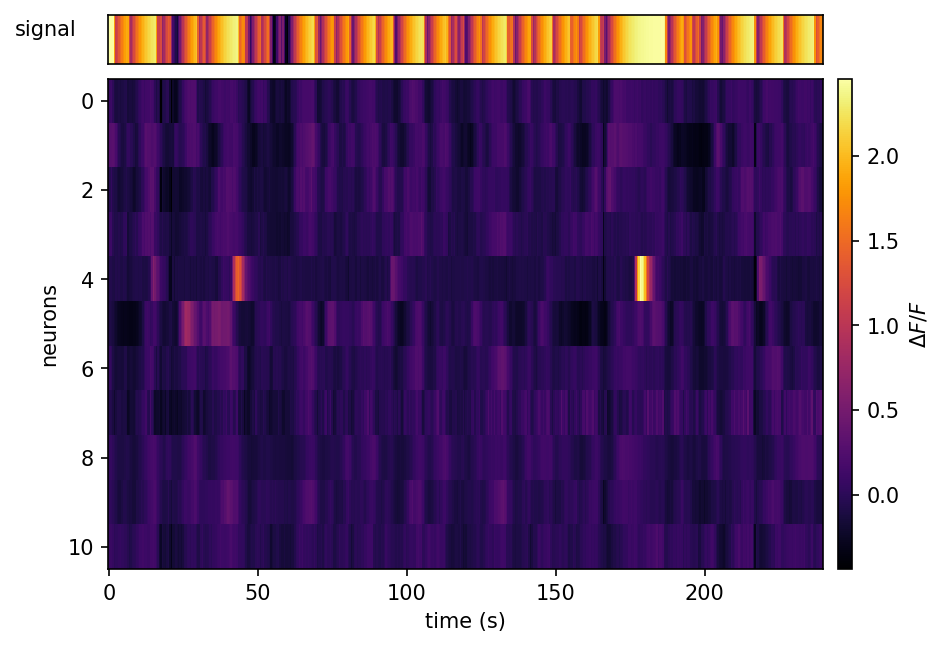

In [74]:
#show fluorescence traces with colormap ordered by decreasing covariance
fig,ax=plt.subplots(dpi=150)
divider=make_axes_locatable(ax)

tax=divider.append_axes('top', size="10%", pad=0.1)
cax=divider.append_axes('right', size="2%", pad=0.1)

dt=(brain_times[-1]-brain_times[0])/len(brain_times)

im1=tax.imshow(np.reshape(signal,(1,-1)),cmap='inferno',interpolation='none',aspect='auto',extent=[brain_times[0]-dt/2,brain_times[-1]+dt/2,len(indices_thr)-0.5,-0.5])

tax.tick_params(axis='both',which='both',bottom=False,left=False,labelbottom=False,labelleft=False)
tax.set_ylabel('signal',rotation=0,labelpad=30)

im2=ax.imshow(brain_fluorescence[indices_thr][:,:],cmap='inferno',interpolation='none',aspect='auto',extent=[brain_times[0]-dt/2,brain_times[-1]+dt/2,len(indices_thr)-0.5,-0.5])

cbar=plt.colorbar(im2,cax=cax)
cbar.set_label(r'$\Delta F/F$')

ax.set_xlabel('time (s)')
ax.set_ylabel('neurons')

plt.show()

### Covariance with stimulus speed:

In [75]:
stimulus_speed_convolved=convolve(stimulus_speed,stimulus_times,brain_times)
signal=center(stimulus_speed_convolved)

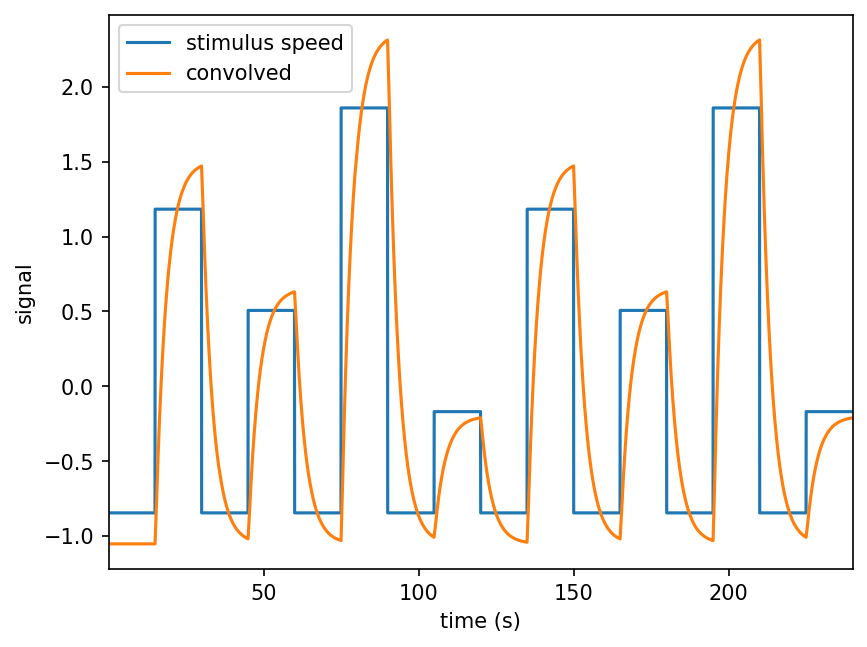

In [76]:
t1=stimulus_times[0]
t2=stimulus_times[-1]

fig,ax=plt.subplots(dpi=150)

ax.plot(stimulus_times,center(stimulus_speed),label='stimulus speed')
ax.plot(brain_times,signal,label='convolved')
ax.set_xlim(t1,t2)
ax.set_xlabel('time (s)')
ax.set_ylabel('signal')
ax.legend()

plt.show()

In [77]:
covariance,indices,indices_thr,characteristic=find_significantly_correlated_neurons(signal,brain_fluorescence,fdr=0.2)

In [78]:
len(indices_thr)

11

In [79]:
#fluorescence traces ordered with decreasing covariance
def f(neuron):
    plt.close()
    fig,ax=plt.subplots(dpi=150)
    ax.plot(brain_times,signal,c='black')
    ax.plot(brain_times,brain_fluorescence[indices[neuron]],'g')
    ax.set_xlim(brain_times[0],brain_times[-1])
    ax.set_xlabel('time (s)')
    ax.set_ylabel('$\Delta F/F$')
    plt.show()

interact(f,neuron=IntSlider(value=0,min=0,max=len(brain_fluorescence)-1,step=1));

interactive(children=(IntSlider(value=0, description='neuron', max=30970), Output()), _dom_classes=('widget-in…

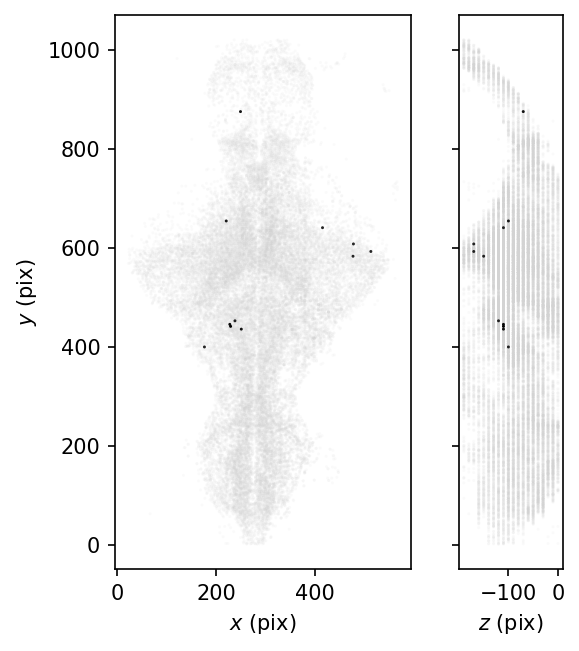

In [80]:
#plot neuron positions colored according to the corresponding covariance
fig, (ax1, ax2) = plt.subplots(1,2,dpi=150,sharey=True)
plt.subplots_adjust(wspace=-0.5)

mask=characteristic.astype(bool)
opacity=covariance/np.max(covariance)
alphas=opacity[mask]
s=2
c='k'

ax1.scatter(brain_coordinates[0,~mask],brain_coordinates[1,~mask],s=s,c='lightgrey',alpha=0.1,edgecolors='none')
ax1.scatter(brain_coordinates[0,mask],brain_coordinates[1,mask],s=s,c=c,alpha=alphas,edgecolors='none')

ax1.set_aspect('equal')
ax1.set_xlabel('$x$ (pix)')
ax1.set_ylabel('$y$ (pix)')

ax2.scatter(brain_coordinates[2,~mask],brain_coordinates[1,~mask],s=s,c='lightgrey',alpha=0.1,edgecolors='none')
ax2.scatter(brain_coordinates[2,mask],brain_coordinates[1,mask],s=s,c=c,alpha=alphas,edgecolors='none')

ax2.set_aspect('equal')
ax2.set_xlabel('$z$ (pix)')

plt.show()

In [81]:
#plots layer by layer
zs=np.unique(brain_coordinates[2])
zs=-np.sort(-zs) #ordered heights of the layers

mask=characteristic.astype(bool)
opacity=covariance/np.max(covariance)

def f(layer):
    plt.close()
    fig,ax=plt.subplots(dpi=150)
    s=1
    offmask_l=(brain_coordinates[2]==zs[layer])&(~mask)
    mask_l=(brain_coordinates[2]==zs[layer])&(mask)
    xlayer=brain_coordinates[0,offmask_l]
    ylayer=brain_coordinates[1,offmask_l]
    ax.scatter(xlayer,ylayer,s=s,c='lightgrey',alpha=0.5)
    xlayer=brain_coordinates[0,mask_l]
    ylayer=brain_coordinates[1,mask_l]
    alphas=opacity[(brain_coordinates[2]==zs[layer])&(mask)]
    if len(xlayer)>0:
        ax.scatter(xlayer,ylayer,s=s,c='black',alpha=alphas)

    ax.set_aspect('equal')
    ax.set_xlim(np.min(brain_coordinates[0]),np.max(brain_coordinates[0]))
    ax.set_ylim(np.min(brain_coordinates[1]),np.max(brain_coordinates[1]))
    ax.set_title('$z = $'+str(zs[layer]))
    ax.set_xlabel('$x$ (pix)')
    ax.set_ylabel('$y$ (pix)')
    plt.show()

interact(f,layer=IntSlider(value=0,min=0,max=len(zs)-1,step=1));

interactive(children=(IntSlider(value=0, description='layer', max=19), Output()), _dom_classes=('widget-intera…

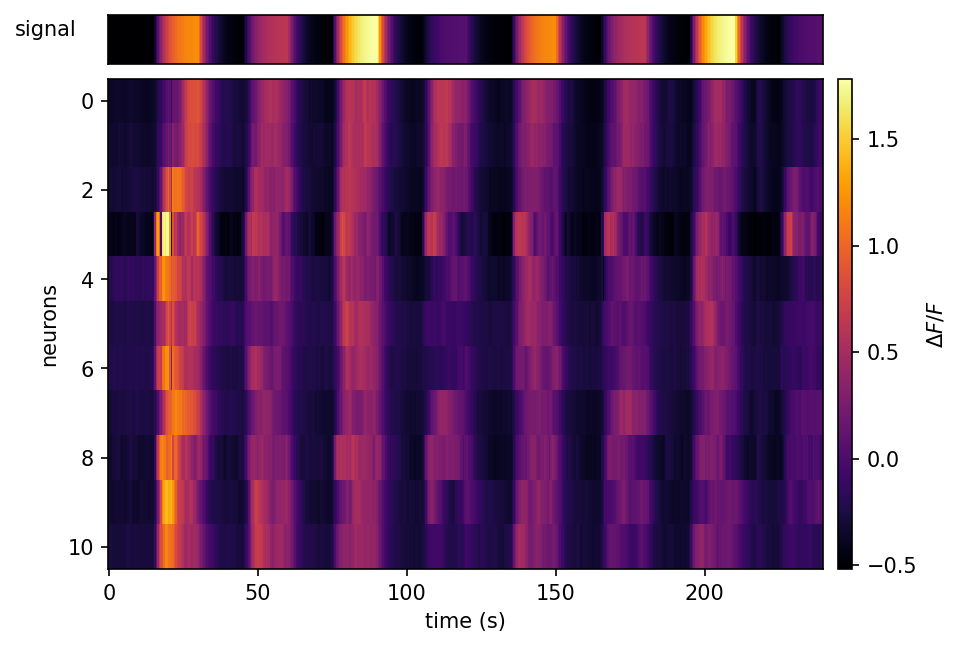

In [82]:
#show fluorescence traces with colormap ordered by decreasing covariance
fig,ax=plt.subplots(dpi=150)
divider=make_axes_locatable(ax)

tax=divider.append_axes('top', size="10%", pad=0.1)
cax=divider.append_axes('right', size="2%", pad=0.1)

dt=(brain_times[-1]-brain_times[0])/len(brain_times)

im1=tax.imshow(np.reshape(signal,(1,-1)),cmap='inferno',interpolation='none',aspect='auto',extent=[brain_times[0]-dt/2,brain_times[-1]+dt/2,len(indices_thr)-0.5,-0.5])

tax.tick_params(axis='both',which='both',bottom=False,left=False,labelbottom=False,labelleft=False)
tax.set_ylabel('signal',rotation=0,labelpad=30)

im2=ax.imshow(brain_fluorescence[indices_thr][:,:],cmap='inferno',interpolation='none',aspect='auto',extent=[brain_times[0]-dt/2,brain_times[-1]+dt/2,len(indices_thr)-0.5,-0.5])

cbar=plt.colorbar(im2,cax=cax)
cbar.set_label(r'$\Delta F/F$')

ax.set_xlabel('time (s)')
ax.set_ylabel('neurons')

plt.show()